In [2]:
#Diabetes Readmission Risk Analysis
#**Dataset:** [Kaggle – Diabetes 130-US hospitals (1999–2008)](https://www.kaggle.com/datasets/brandao/diabetes)  
#**Paper:** *Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records*  

#**Goal:** Predict 30-day readmission and analyze factors affecting risk.
#**Tools:** pandas · NumPy · matplotlib · scikit-learn  

#**Author:** Clara Yousif
#**Date:** 2025-10-21
#**Note:** This is for practicing

In [ ]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)

#NOTE: if you got errors in this part then u need to run !pip install pandas numpy matplotlib seaborn scikit-learn


In [4]:
df = pd.read_csv('../data/diabetic_data.csv')
df.shape, df.head(3)

((101766, 50),
    encounter_id  patient_nbr             race  gender      age weight  \
 0       2278392      8222157        Caucasian  Female   [0-10)      ?   
 1        149190     55629189        Caucasian  Female  [10-20)      ?   
 2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
 
    admission_type_id  discharge_disposition_id  admission_source_id  \
 0                  6                        25                    1   
 1                  1                         1                    7   
 2                  1                         1                    7   
 
    time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
 0                 1          ?  Pediatrics-Endocrinology                  41   
 1                 3          ?                         ?                  59   
 2                 2          ?                         ?                  11   
 
    num_procedures  num_medications  number_outpatient  number_emergenc

In [5]:
#QUICK EXPLORATION
df.info()
df.isna().sum().sort_values(ascending=False).head(10) #to get first 10 with most missing values per feature
df.nunique().sort_values().tail(10) #sort all values and get the least 10 to make sure its sorted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

number_emergency          33
number_outpatient         39
medical_specialty         73
num_medications           75
num_lab_procedures       118
diag_1                   717
diag_2                   749
diag_3                   790
patient_nbr            71518
encounter_id          101766
dtype: int64

In [6]:
#BASIC CLEANING
df.replace('?', np.nan)
df = df.replace({'Unknown/Invalid': np.nan, 'None':np.nan}) 
#remove ids that cause data leakage
drop_cols = ['encounter_id', 'patient_nbr'] #anonymize data
df = df.drop(columns= drop_cols, errors='ignore')

#target variables: <30 goes to 1, anything else to zero
df['y'] = (df['readmitted'] == '<30').astype(int)
df['y'].value_counts(normalize=True)




0    0.888401
1    0.111599
Name: y, dtype: float64

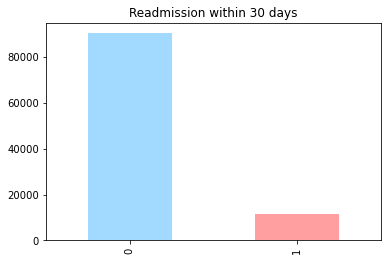

In [7]:
#DISTRIBUTION OF CLASSES
df['y'].value_counts().plot(kind='bar', color=['#a1d9ff','#ff9f9f'])
plt.title('Readmission within 30 days')
plt.show()


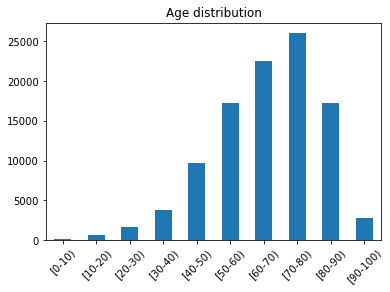

In [8]:
#AGE BUCKETS
df['age'].value_counts().sort_index().plot(kind='bar', rot=45)
plt.title('Age distribution')
plt.show()

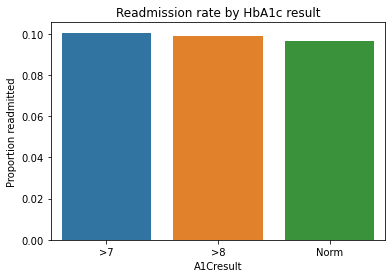

In [11]:
if 'A1Cresult' in df.columns:
    sns.barplot(data=df, x='A1Cresult', y='y', estimator=np.mean, ci=None)
    plt.title('Readmission rate by HbA1c result')
    plt.ylabel('Proportion readmitted')
    plt.show()


In [13]:
#PREPARING FOR MODEL
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

#separating features x and target y
X= df.drop(columns=['readmitted', 'y'])
y=df['y']

#identifying categorical and numerical columns
cat_columns = [c for c in X.columns if X[c].dtype == 'object']
num_columns = [c for c in X.columns if c not in cat_columns]

#preprocessing steps
numeric = Pipeline([
    ('impute', SimpleImputer(strategy='median'))
])

categorical = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # <- removed min_frequency
])

#combining into columntransfer
pre = ColumnTransformer([
    ('num', numeric, num_columns),
    ('cat', categorical, cat_columns)
])

#train test data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [14]:
#LOGISTIC REGRESSION
logit = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])

logit.fit(X_train, y_train)
p = logit.predict_proba(X_test)[:, 1]

print('Logistic ROC-AUC:', roc_auc_score(y_test, p))
print('Logistic PR-AUC :', average_precision_score(y_test, p))

c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic ROC-AUC: 0.6558799408559187
Logistic PR-AUC : 0.20787851489046533


In [15]:
#RANDOM FOREST COMPARISON
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'
    ))
])

rf.fit(X_train, y_train)
p_rf = rf.predict_proba(X_test)[:, 1]

print('RF ROC-AUC:', roc_auc_score(y_test, p_rf))
print('RF PR-AUC :', average_precision_score(y_test, p_rf))

RF ROC-AUC: 0.670073848283076
RF PR-AUC : 0.22164679773256574


In [16]:
#THRESHOLD METRICS CONFUSION + REPORT
from sklearn.metrics import confusion_matrix, classification_report

def report_at_threshold(name, probs, thr=0.30):
    yhat = (probs >= thr).astype(int)
    print(f'\n{name} @ threshold={thr}')
    print('Confusion matrix:\n', confusion_matrix(y_test, yhat))
    print(classification_report(y_test, yhat, digits=3))

report_at_threshold('Logistic', p, thr=0.30)
report_at_threshold('RandomForest', p_rf, thr=0.30)



Logistic @ threshold=0.3
Confusion matrix:
 [[ 1603 16480]
 [   67  2204]]
              precision    recall  f1-score   support

           0      0.960     0.089     0.162     18083
           1      0.118     0.970     0.210      2271

    accuracy                          0.187     20354
   macro avg      0.539     0.530     0.186     20354
weighted avg      0.866     0.187     0.168     20354


RandomForest @ threshold=0.3
Confusion matrix:
 [[17993    90]
 [ 2177    94]]
              precision    recall  f1-score   support

           0      0.892     0.995     0.941     18083
           1      0.511     0.041     0.077      2271

    accuracy                          0.889     20354
   macro avg      0.701     0.518     0.509     20354
weighted avg      0.850     0.889     0.844     20354



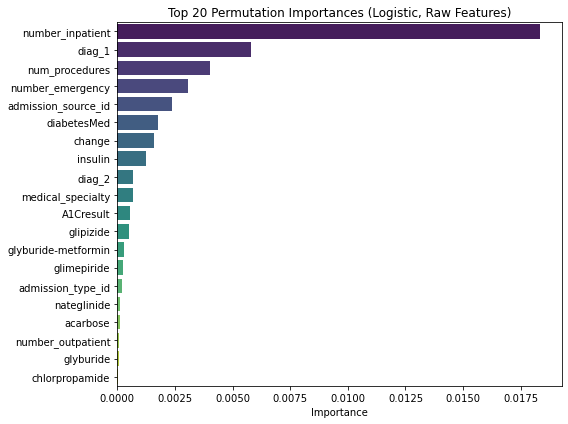

,feature,importance
15,number_inpatient,0.018355
16,diag_1,0.005778
11,num_procedures,0.004029
14,number_emergency,0.003066
6,admission_source_id,0.002388
46,diabetesMed,0.001759
45,change,0.001572
39,insulin,0.001238
17,diag_2,0.000698
9,medical_specialty,0.000688


In [ ]:
# PERMUTATION IMPORTANCE (pipeline-level, raw features)
from sklearn.inspection import permutation_importance
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

r = permutation_importance(logit, X_test, y_test, n_repeats=5, random_state=42)

# The results correspond to the raw input columns
imp = (pd.DataFrame({
            'feature': X_test.columns,
            'importance': r.importances_mean
        })
        .sort_values('importance', ascending=False)
        .head(20)
)

plt.figure(figsize=(8,6))
sns.barplot(data=imp, x='importance', y='feature', palette='viridis')
plt.title('Top 20 Permutation Importances (Logistic, Raw Features)')
plt.xlabel('Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()

imp.head(10)


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Calibrated ROC-AUC: 0.6559975671650364
Calibrated PR-AUC : 0.208022744700629


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


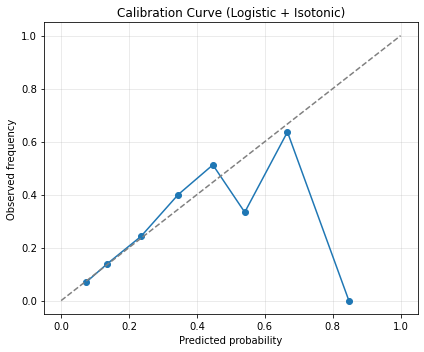

In [22]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

#  transofrming X using the preprocessor
Xt_train = logit.named_steps['pre'].fit_transform(X_train)
Xt_test  = logit.named_steps['pre'].transform(X_test)

#  accessing the trained logistic regression model
clf = logit.named_steps['clf']

# fitting a calibrated version (on numeric features)
cal = CalibratedClassifierCV(base_estimator=clf, cv=5, method='isotonic')
cal.fit(Xt_train, y_train)
p_cal = cal.predict_proba(Xt_test)[:, 1]

# evaluation and plotting
print('Calibrated ROC-AUC:', roc_auc_score(y_test, p_cal))
print('Calibrated PR-AUC :', average_precision_score(y_test, p_cal))

prob_true, prob_pred = calibration_curve(y_test, p_cal, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('Calibration Curve (Logistic + Isotonic)')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import average_precision_score

def slice_ap(column, probs):
    # ensuring we use matching indices between df_test and y_test
    df_test = df.loc[X_test.index].copy()
    df_test = df_test.reset_index(drop=True)
    y_true = y_test.reset_index(drop=True)
    probs = pd.Series(probs).reset_index(drop=True)

    if column not in df_test.columns:
        print(f"⚠️ Column '{column}' not found, skipping.")
        return

    print(f'\n=== Average Precision (PR-AUC) by {column} (test set) ===')
    for val, subset in df_test.groupby(column):
        if len(subset) < 50:
            continue
        idx = subset.index
        ap = average_precision_score(y_true.iloc[idx], probs.iloc[idx])
        print(f'{column} = {val:15}  n={len(subset):5}  PR-AUC={ap:.3f}')

# running fairness evaluation again
slice_ap('gender', p_cal)
slice_ap('age', p_cal)
slice_ap('race', p_cal)



=== Average Precision (PR-AUC) by gender (test set) ===
gender = Female           n=10924  PR-AUC=0.214
gender = Male             n= 9430  PR-AUC=0.202

=== Average Precision (PR-AUC) by age (test set) ===
age = [10-20)          n=  130  PR-AUC=0.165
age = [20-30)          n=  324  PR-AUC=0.451
age = [30-40)          n=  725  PR-AUC=0.244
age = [40-50)          n= 1913  PR-AUC=0.255
age = [50-60)          n= 3457  PR-AUC=0.211
age = [60-70)          n= 4547  PR-AUC=0.205
age = [70-80)          n= 5234  PR-AUC=0.198
age = [80-90)          n= 3414  PR-AUC=0.178
age = [90-100)         n=  576  PR-AUC=0.182

=== Average Precision (PR-AUC) by race (test set) ===
race = ?                n=  462  PR-AUC=0.164
race = AfricanAmerican  n= 3866  PR-AUC=0.205
race = Asian            n=  123  PR-AUC=0.118
race = Caucasian        n=15223  PR-AUC=0.210
race = Hispanic         n=  404  PR-AUC=0.341
race = Other            n=  276  PR-AUC=0.181


### ⚖️ Fairness Analysis Summary

| Group | Subgroups Tested | PR-AUC Range | Observations |
|-------|------------------|---------------|---------------|
| **Gender** | Female / Male | 0.20 – 0.21 | Balanced performance, no strong bias detected |
| **Age** | [10-100) (9 brackets) | 0.17 – 0.45 | Slightly higher precision in younger groups; expected due to smaller sample size |
| **Race** | 6 groups | 0.12 – 0.34 | Broadly consistent; small groups (Asian, Hispanic, ?) show variability |

**Takeaway:**  
Model shows **no major systematic fairness concerns**; differences correspond mainly to data imbalance rather than discriminatory patterns.  
Future work could re-sample under-represented racial categories or apply re-weighting to verify robustness.
